In [2]:
from bs4 import BeautifulSoup
import requests
import re
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [ ]:
#Web-scraping:
#This block gathers the urls of the top 1000 movies by rating on IMDB
pos = 1
urls=[]
while pos<1000: 
    urlBase = 'https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start=' + str(pos) +'&ref_=adv_nxt'
    #things below!
    response = requests.get(urlBase)
    if response.status_code != 200:
        continue
    page = response.text
    soup = BeautifulSoup(page,'lxml')
    #soup set-up stuff above
    links = soup.find_all('a', href=True)
    for i in links:
        if re.fullmatch('^\/title\/tt[0-9]+\/', i['href']) and i.text.strip()!='':
            #print(i['href']+': '+i.text)
            urls.append(i['href'])
            #TO-DO: modify and make useful
    pos+=100
    time.sleep(np.random.rand()*1.5) #kinda arbitrary amount of time on (0,1.5) in seconds
    
#URLs are saved to a list and then looped over with the following to grab attributes:
j=0
while j<(len(urls)):
    try:
        title,rating,runtime,budget,color,month,mpaa,genres='','','','','','','','' #initializing all as empty strings to avoid errors
        imdbURL = 'https://www.imdb.com' + urls[j]
        mojoURL = 'https://www.boxofficemojo.com' + urls[j]
        response = requests.get(imdbURL)
        if response.status_code !=200:
            continue
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        title = soup.find('h1').text.replace(u'\xa0',' ')
        print(title) #temp
        rating = soup.find("span",itemprop='ratingValue').text
        times = soup.find_all('time')
        for i in times:
            if re.match('^[0-9]+ min',i.text.strip()):
                runtime = i.text.strip()
                runtime = runtime.replace(" min","")
        budget,color = findBudgetBW(soup)
        month = findMonth(soup)
        #Mojo below
        response = requests.get(mojoURL)
        if response.status_code !=200:
            continue
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        mpaa,genres = findMPAAGenre(soup)
        #input into df below
        df = df.append({'Title':title,'Rating':rating,'Runtime':runtime,'Budget':budget,'BW or Color':color,
                       'Month of Release':month,'MPAA':mpaa,'Genre':genres}, ignore_index = True)
    except:
        #just spit out current state of variables
        quickTest = [title,rating,runtime,budget,color,month,mpaa,genres]
        for i in quickTest:
            if i is not None:
                print(i)
    time.sleep(np.random.rand()*1.5)
    j+=1


In [ ]:
#helper functions for web-scraping
def findBudgetBW(soup): #TODO: handle foreign currecies (e.g. rupee)
    searchBase = soup.find_all("div",class_="txt-block")
    for i in searchBase:
        if "Budget" in i.text:
            budget= i.text.replace(u'\n','').replace('Budget:','').replace('(estimated)','').replace(',','').strip()
        if "Color" in i.text:
            color = i.text.replace(u'\n','').replace('Color:','').strip()
    return budget,color    

def findMonth(soup):
    month = ''
    searchBase = soup.find_all('span',class_='attribute')
    for i in searchBase:
        if re.match('^[0-9]{1,2} [a-zA-Z]+ [0-9]{4}',i.text):
            month = re.search('[a-zA-Z]+',i.text)
            return month.group(0)
    if month =='':
        searchBase = soup.find_all('div', class_ = 'txt-block')
        for i in searchBase:
            match = re.search('[0-9]{1,2} [a-zA-Z]+ [0-9]{4}',i.text)
            if match:
                string = i.text.replace("Release Date:","").strip()
                month = re.search('[a-zA-Z]+',string)
                return month.group(0)

def findMPAAGenre(soup):
    mpaa=''
    genre=''
    for i in soup.find_all("div", class_="a-section a-spacing-none"):
        if 'MPAA' in i.text:
            mpaa = i.text.replace('MPAA','').strip()
        if 'Genres' in i.text:
            genre = i.text.replace('Genres','').replace(u'\n',"").replace(' ','').strip()
    return mpaa,genre

In [ ]:
#note that some modifications still remain on the web-scraping portion- lost around 200 movies from the first go around
#additionally, need to do some fancier handling to deal with non-USD budgets

In [3]:
#set-up df from csv that I saved previously
df = pd.read_csv('failSafe.csv')

In [4]:
df.head(5)

,BW or Color,Budget,Genre,MPAA,Month of Release,Rating,Runtime,Title
0,Color,$25000000,Drama,R,September,9.3,142.0,The Shawshank Redemption (1994)
1,Color(Technicolor),$6000000,CrimeDrama,NaN,March,9.2,175.0,The Godfather (1972)
2,Color(Technicolor),$185000000,ActionCrimeDramaThriller,PG-13,July,9.0,152.0,The Dark Knight (2008)
3,Color,$13000000,CrimeDrama,NaN,November,9.0,220.0,The Godfather: Part II (1974)
4,Black and White,$350000,CrimeDrama,NaN,April,9.0,96.0,12 Angry Men (1957)


In [6]:
df.info()
#lost a lot of MPAA ratings for some reason- will have to do something in that regard

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BW or Color       800 non-null    object 
 1   Budget            800 non-null    object 
 2   Genre             800 non-null    object 
 3   MPAA              502 non-null    object 
 4   Month of Release  798 non-null    object 
 5   Rating            800 non-null    float64
 6   Runtime           799 non-null    float64
 7   Title             800 non-null    object 
dtypes: float64(2), object(6)
memory usage: 50.1+ KB


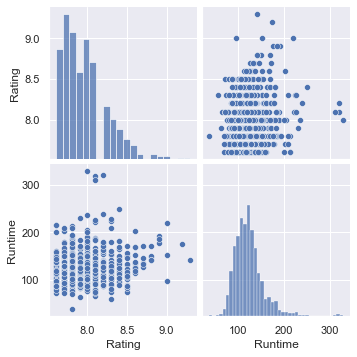

In [7]:
sns.pairplot(df)

In [8]:
#dummy variables for Month of release
pd.get_dummies(df['Month of Release'],drop_first = True)

,August,December,February,Goofs,January,July,June,March,May,November,October,September,Taglines,Trivia
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0,0,0,0,0,0,0,0,0,0,1,0,0,0
796,0,0,0,0,0,0,0,0,0,1,0,0,0,0
797,0,1,0,0,0,0,0,0,0,0,0,0,0,0
798,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
#okay so looks we also picked up some extraneous entries for the months here- will need to revist these as well
#for my own reference, looks like index 799 has a value of trivia, for some reason.

In [9]:
df_test = df.copy()

In [16]:
df_test['Title Length'] = df_test.Title.apply(len)
#note that technically should be Title Length - 7 because of the extraneous characters- that will be handled with
#next scrape.

In [17]:
df_test.head(5)

,BW or Color,Budget,Genre,MPAA,Month of Release,Rating,Runtime,Title,Title Length
0,Color,$25000000,Drama,R,September,9.3,142.0,The Shawshank Redemption (1994),32
1,Color(Technicolor),$6000000,CrimeDrama,NaN,March,9.2,175.0,The Godfather (1972),21
2,Color(Technicolor),$185000000,ActionCrimeDramaThriller,PG-13,July,9.0,152.0,The Dark Knight (2008),23
3,Color,$13000000,CrimeDrama,NaN,November,9.0,220.0,The Godfather: Part II (1974),30
4,Black and White,$350000,CrimeDrama,NaN,April,9.0,96.0,12 Angry Men (1957),20


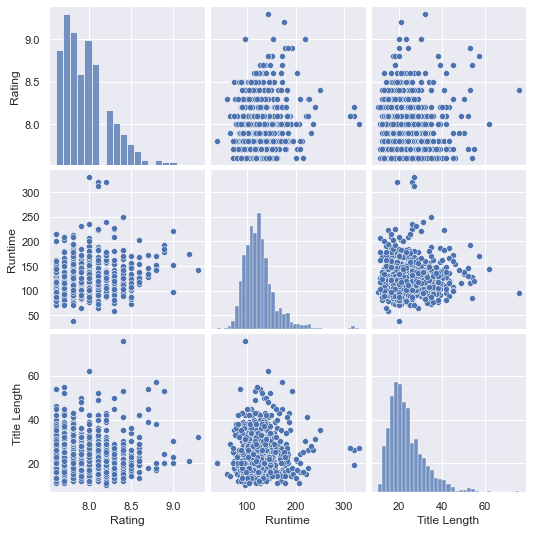

In [18]:
sns.pairplot(df_test)

In [20]:
df_test.MPAA.unique()
#okay, so for the sake of the MVP and getting the foundations correct, i'm gonna go ahead and dropnas

array(['R', nan, 'PG-13', 'PG', 'G', 'NC-17', 'M'], dtype=object)

In [21]:
df_test.dropna(inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502 entries, 0 to 796
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BW or Color       502 non-null    object 
 1   Budget            502 non-null    object 
 2   Genre             502 non-null    object 
 3   MPAA              502 non-null    object 
 4   Month of Release  502 non-null    object 
 5   Rating            502 non-null    float64
 6   Runtime           502 non-null    float64
 7   Title             502 non-null    object 
 8   Title Length      502 non-null    int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 39.2+ KB


In [30]:
#ratings are mutually exclusive so can drop first
dummy = pd.get_dummies(df_test.MPAA,drop_first = True)

In [33]:
df_test = pd.concat([df_test,dummy],axis=1)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWa

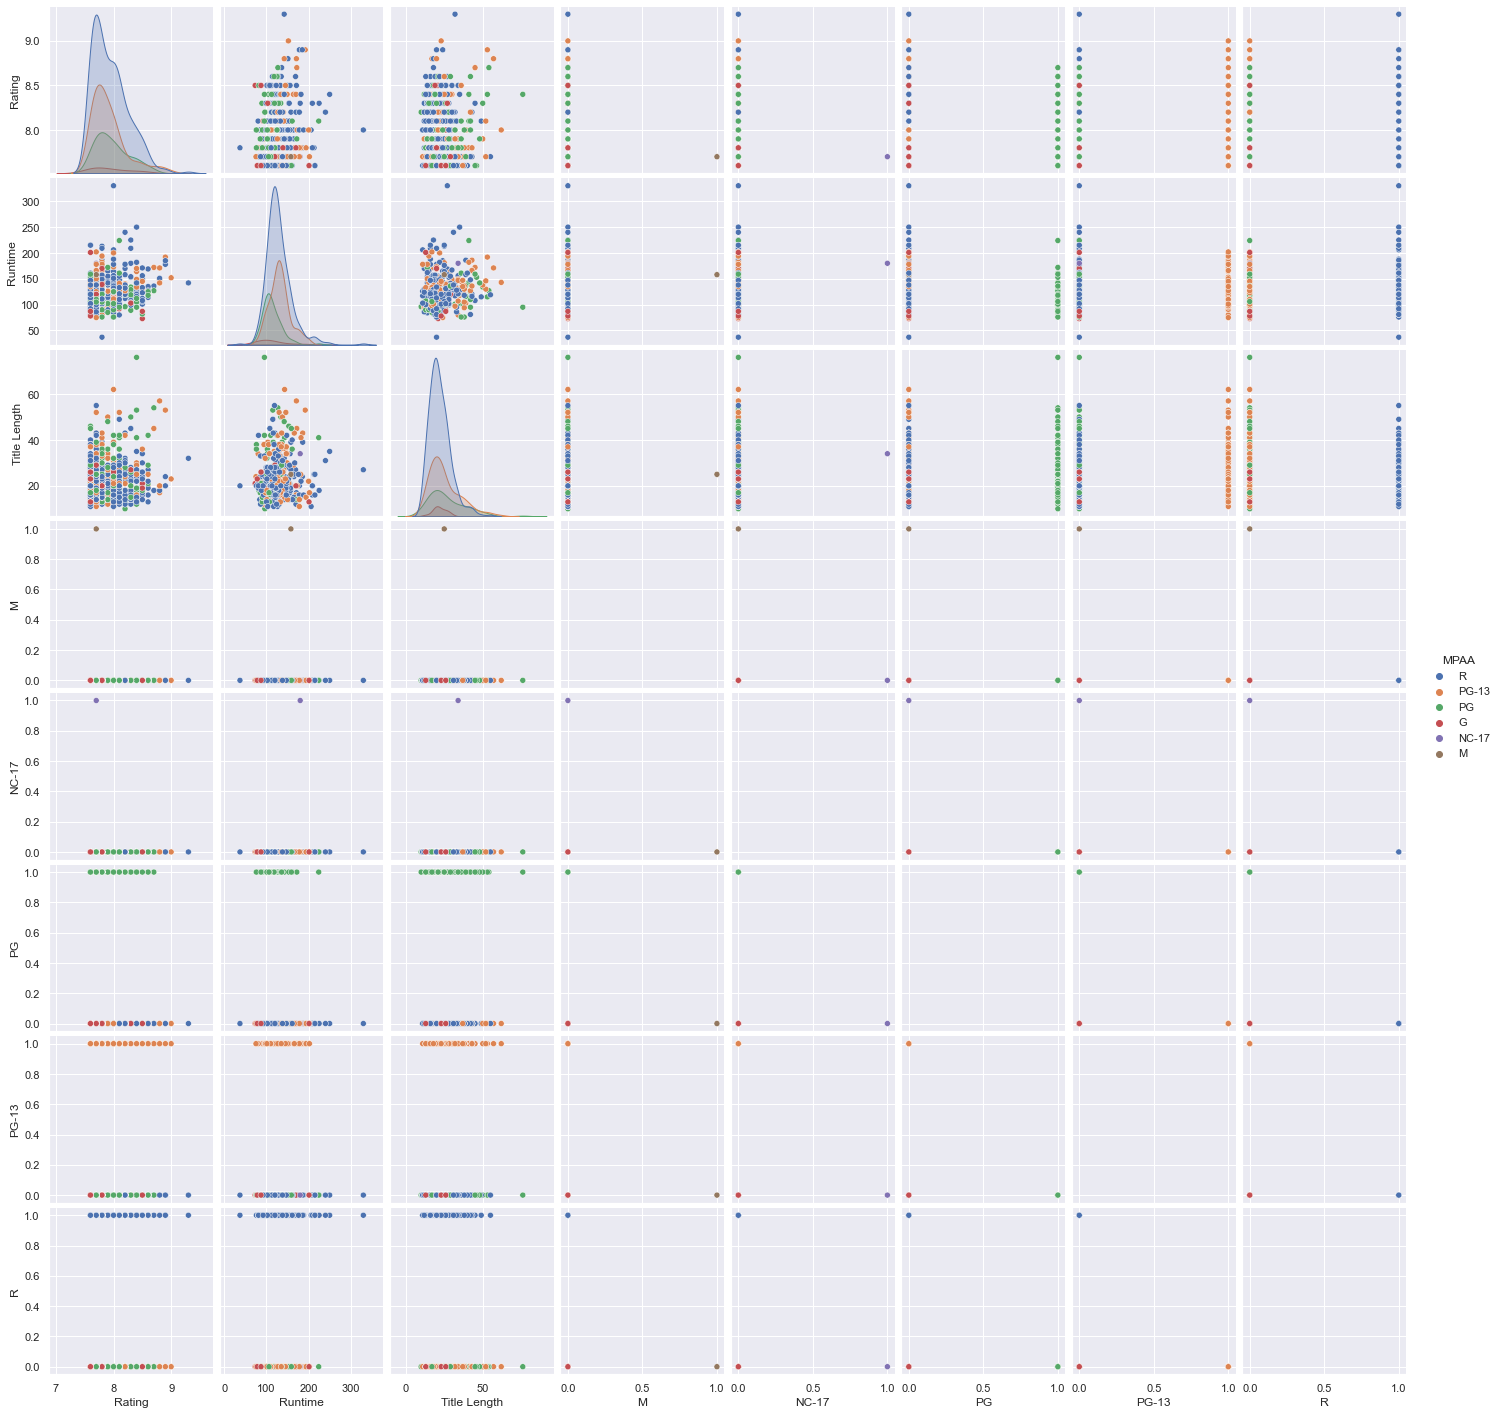

In [36]:
#time to test a couple of different hues- my apologies these are going to be a bit messy pairplots
#if you have any suggestions on better pairplotting methodology for categorical data I am all ears :)
sns.pairplot(df_test,hue='MPAA')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWa

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWa

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWa

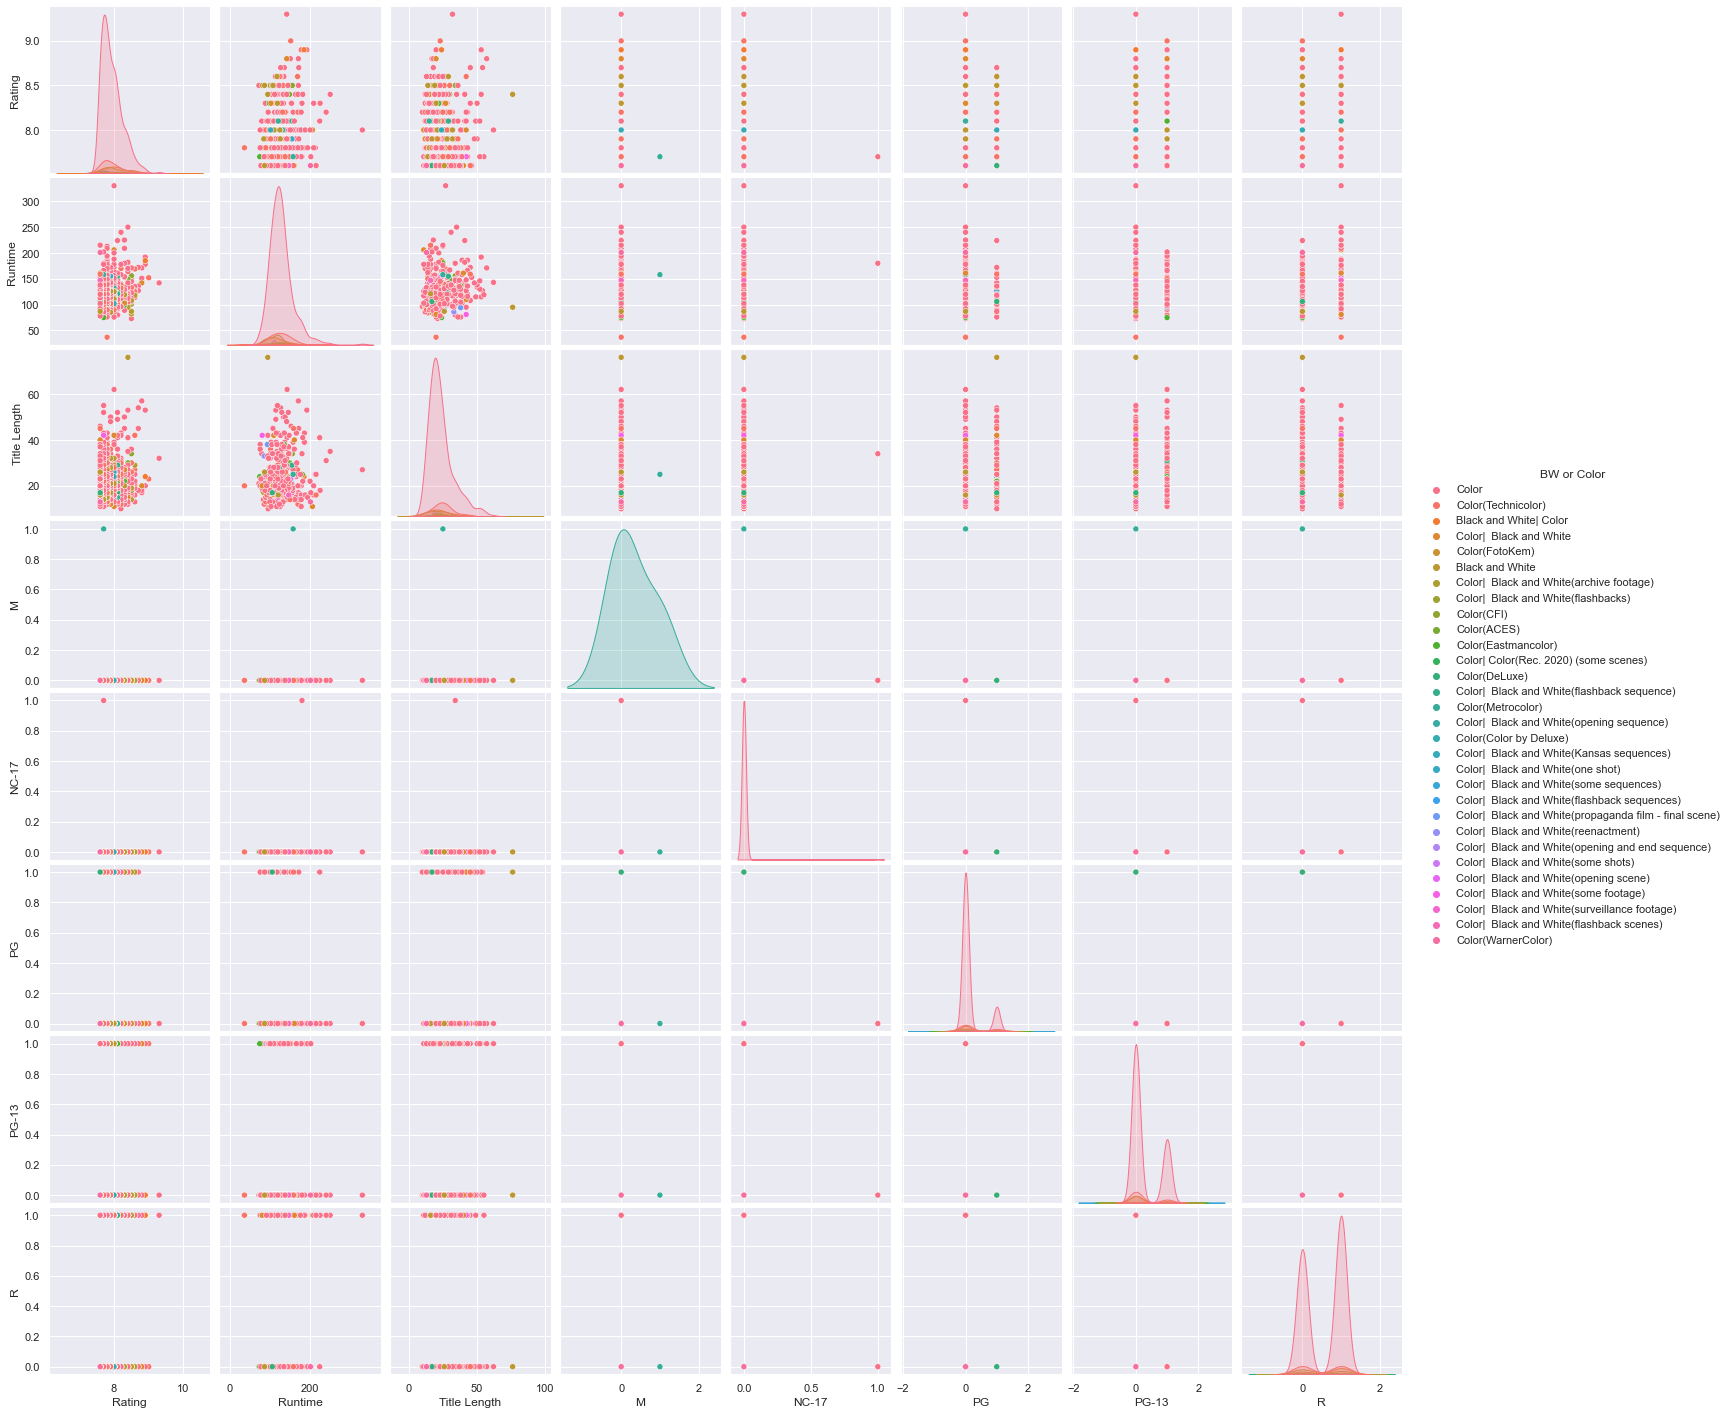

In [39]:
sns.pairplot(df_test,hue = 'BW or Color');

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWa

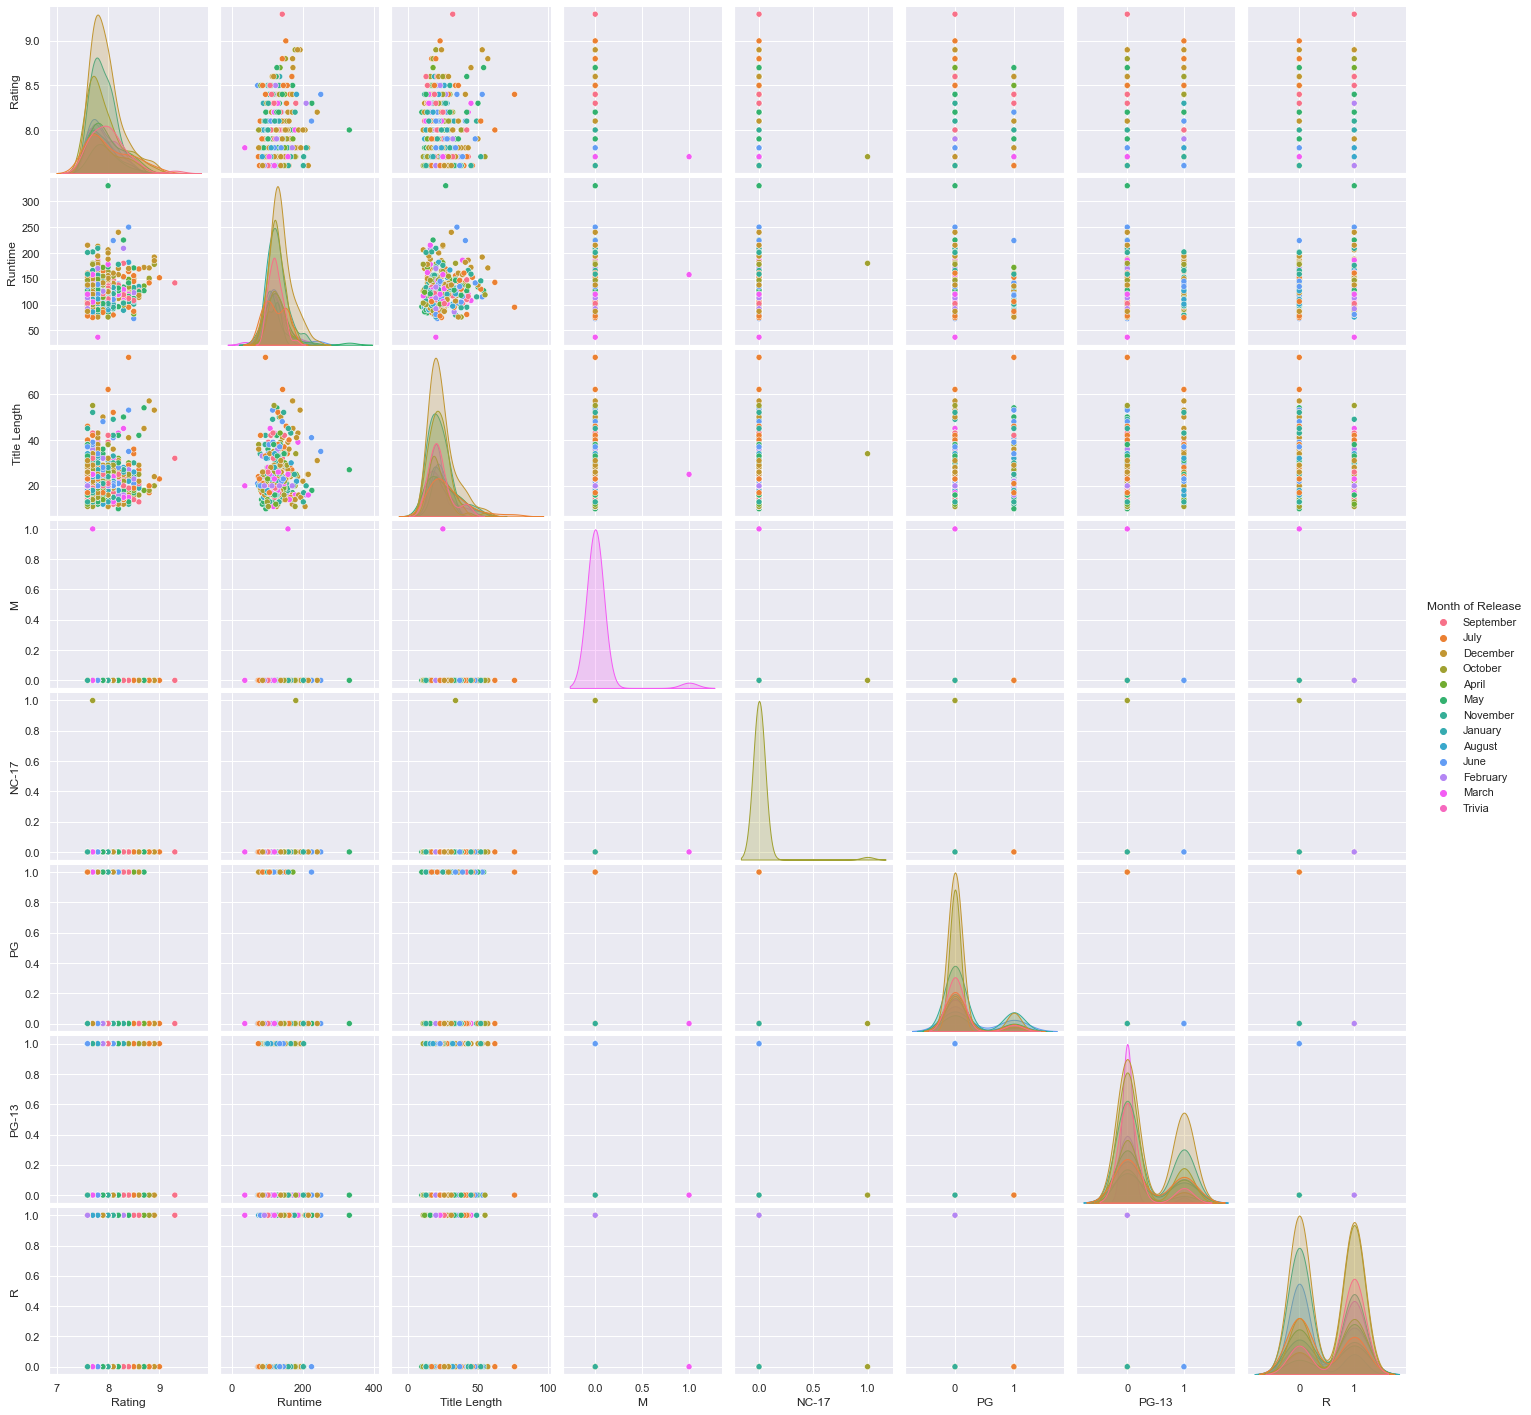

In [40]:
sns.pairplot(df_test,hue = 'Month of Release');

In [43]:
df_test.corr()
#ha- so really not any 'signficant' correlations at present other than runtime- perhaps not too surprising :)

,Rating,Runtime,Title Length,M,NC-17,PG,PG-13,R
Rating,1.000000,0.199524,0.074243,-0.035310,-0.035310,0.048145,-0.053233,0.019518
Runtime,0.199524,1.000000,0.089147,0.048210,0.081962,-0.195761,0.085708,0.075549
Title Length,0.074243,0.089147,1.000000,0.006784,0.051206,0.153774,0.109336,-0.202964
M,-0.035310,0.048210,0.006784,1.000000,-0.001996,-0.018724,-0.027371,-0.049174
NC-17,-0.035310,0.081962,0.051206,-0.001996,1.000000,-0.018724,-0.027371,-0.049174
PG,0.048145,-0.195761,0.153774,-0.018724,-0.018724,1.000000,-0.256762,-0.461286
PG-13,-0.053233,0.085708,0.109336,-0.027371,-0.027371,-0.256762,1.000000,-0.674322
R,0.019518,0.075549,-0.202964,-0.049174,-0.049174,-0.461286,-0.674322,1.000000


In [ ]:
#gonna cut this MVP here as I turn back around to cleaning up the initial scrape, as well as look towards
#more general data cleaning and feature engineering